# Data wrangling scripts

## Imports and function definitions

In [1]:
import os
import rasterio as rio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import glob
import shutil
import utils
import tifffile as tiff

%load_ext autoreload
%autoreload 2

def rescale_and_save(in_fn):
    fn = in_fn.replace("10cm", "20cm")
    out_fn_rgb = fn.replace(".tif", "_rgb.tif")
    out_fn_nir = fn.replace(".tif", "_nir.tif")
    
    if not os.path.exists(fn.split("/Ortho")[0]):
        os.makedirs(os.path.join(fn.split("/Ortho")[0], "Ortho"))
        
    r =  rio.open(in_fn)
    downscale_factor = 0.5
    r_arr = r.read(
        out_shape=(
                r.count,
                int(r.height * downscale_factor),
                int(r.width * downscale_factor)
            ),
            resampling=Resampling.bilinear
    )


    type(r_arr)
    # r_arr = np.moveaxis(r_arr, 0, -1)

    for i in range(4):
        max = r_arr[i].max()
        r_arr[i] = (r_arr[i] / max) * 255
    # r_arr = np.flip(r_arr[0:3, ...], axis=0)
    R = r_arr[2].copy()
    G = r_arr[1]
    B = r_arr[0].copy()

    r_arr[0] = R
    r_arr[2] = B

    # scale image transform
    transform = r.transform * r.transform.scale(
        (r.width / r_arr.shape[-1]),
        (r.height / r_arr.shape[-2])
    )

    rgb_profile = r.profile.copy()
    rgb_profile.update(
        driver="GTiff",
        height=r_arr.shape[1],
        width=r_arr.shape[2],
        dtype=r_arr.dtype,
        count=3,
        transform=transform
    )

    nir_profile = rgb_profile.copy()
    nir_profile.update(
        count=1
    )

    new_rgb = rio.open(
        out_fn_rgb,
        'w',
        **rgb_profile
    )
    new_nir = rio.open(
        out_fn_nir,
        'w',
        **nir_profile
    )
    new_rgb.write(r_arr[0:3])
    new_nir.write(np.expand_dims(r_arr[3], 0))

## Downsample 10 cm files to 20 cm with radiometric rescaling and save

In [ ]:
RESCALE = False

if RESCALE:
    dirs = glob.glob("data/*10cm")
    for dir in dirs[1:]:
        fns = glob.glob(os.path.join(dir, "Ortho/*.tif"))
        for fn in fns:
            rescale_and_save(fn)

## Reorganize files

Desired file structure:
- {location}
    - {resolution}
        - Ortho
            - {tilename}
                - rgb
                    - {tilename}_rgb.tif
                - cir
                    - {tilename}_cir.tif
                - labels
                    - {tilename}_labels.tif

In [6]:
REORGANIZE = False

if REORGANIZE:

    DATA_DIR = "data"
    IM_DIRS = ["rgb", "nir", "labels"]
    dirs = glob.glob(f"data/WA_Shishmaref_01_20210628/")
    tilenames = []

    for dir in dirs:
        dir = os.path.join(dir, "20cm/Ortho")
        files = glob.glob(f"{dir}/*.tif")
        
        for file in files:
            # Get the tilename
            tilename = os.path.basename(file).rsplit("_", 1)[0]
            tile_dir = os.path.join(dir, tilename)

            if not os.path.exists(tile_dir):
                # Create the tile directory and subdirectories
                # shutil.rmtree(tile_dir)
                os.mkdir(tile_dir)
                for im_dir in IM_DIRS:
                    os.mkdir(os.path.join(tile_dir, im_dir))
            
            for im_dir in IM_DIRS:
                if file.endswith(f"{im_dir}.tif"):
                    shutil.move(file, os.path.join(tile_dir, im_dir))
        

data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_10_2_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_10_3_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_10_4_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_10_5_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_11_1_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_11_2_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_11_3_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_11_4_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_11_5_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shishmaref_01_20210628_20cm_Ortho_12_1_labels.tif
data/WA_Shishmaref_01_20210628/20cm/Ortho/WA_Shish

## Sandbox for aggregating and patchifying


In [8]:
data_dir = "data/WA_Kotzebue_01_20210625/20cm/Ortho"
dirs = glob.glob(f"{data_dir}/*")
IM_DIRS = ["rgb", "nir", "labels"]
rgb_fns, nir_fns, label_fns = [], [], []

for dir in dirs:
    rgb = glob.glob(f"{dir}/rgb/*.tif")[0]
    nir = glob.glob(f"{dir}/nir/*.tif")[0]
    labels = glob.glob(f"{dir}/labels/*.tif")[0]
    rgb_fns.append(rgb)
    nir_fns.append(nir)
    label_fns.append(labels)

In [ ]:
for f in rgb_fns:
    im = tiff.imread(f)
    print(im.shape)

In [45]:
k = 0
rgb_im = tiff.imread(rgb_fns[k])
# nir_im = np.expand_dims(tiff.imread(nir_fns[k]), -1)
r = np.dstack((rgb_im, nir_im))

In [64]:
# Allow division by zero
np.seterr(divide="ignore", invalid="ignore")
r = r.astype(np.float64)
ndvi = (r[..., -1] - r[..., 0]) / (r[..., -1] + r[..., 0])
ndvi[np.isnan(ndvi)] = -1
ndvi = (((ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())) * 255).astype(np.uint16)
ndvi


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 150, 152, 152],
       [  0,   0,   0, ..., 145, 149, 151],
       [  0,   0,   0, ..., 143, 147, 149]], dtype=uint16)

In [48]:
labels = tiff.imread(label_fns[k])

In [30]:
def concat_train_test(X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add):
    X_train = np.concatenate((X_train, X_train_add), axis=0)
    y_train = np.concatenate((y_train, y_train_add), axis=0)
    X_test = np.concatenate((X_test, X_test_add), axis=0)
    y_test = np.concatenate((y_test, y_test_add), axis=0)
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = utils.prep_data(
    "data/WA_Kivalina_01_20219703/20cm/Ortho",
    include_nir=False,
    add_ndvi=False,
    squash=True,
    img_size_override=2500,
)

X_train_add, y_train_add, X_test_add, y_test_add = utils.prep_data(
    "data/WA_Kotzebue_01_20210625/20cm/Ortho",
    include_nir=False,
    add_ndvi=False,
    squash=True,
    img_size_override=2500,
)

X_train, y_train, X_test, y_test = concat_train_test(
    X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add
)

X_train_add, y_train_add, X_test_add, y_test_add = utils.prep_data(
    "data/WA_Shishmaref_01_20210628/20cm/Ortho",
    include_nir=False,
    add_ndvi=False,
    squash=True,
    img_size_override=2500,
)

X_train, y_train, X_test, y_test = concat_train_test(
    X_train, y_train, X_test, y_test, X_train_add, y_train_add, X_test_add, y_test_add
)

print("\nFinal concatenated sizes:\n")
print("-------------------------\n")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Number of directories: 23
bad ims length: 2
m: 16
Cull rows: -32
Shape before: (368, 512, 512, 3)
Shape after: (336, 512, 512, 3)

Patched data sizes:
data_train: (336, 512, 512, 3)
data_label: (336, 512, 512, 1)

Dataset sizes:
    X_train: (225, 512, 512, 3)
    y_train: (225, 512, 512, 1)
    X_test: (111, 512, 512, 3)
    y_test: (111, 512, 512, 1)
Number of directories: 45
bad ims length: 4
m: 16
Cull rows: -64
Shape before: (720, 512, 512, 3)
Shape after: (656, 512, 512, 3)

Patched data sizes:
data_train: (656, 512, 512, 3)
data_label: (656, 512, 512, 1)

Dataset sizes:
    X_train: (439, 512, 512, 3)
    y_train: (439, 512, 512, 1)
    X_test: (217, 512, 512, 3)
    y_test: (217, 512, 512, 1)
Number of directories: 49
bad ims length: 3
m: 16
Cull rows: -48
Shape before: (784, 512, 512, 3)
Shape after: (736, 512, 512, 3)

Patched data sizes:
data_train: (736, 512, 512, 3)
data_label: (736, 512, 512, 1)

Dataset sizes:
    X_train: (493, 512, 512, 3)
    y_train: (493, 512, 512, 

In [42]:
X_train_tester = X_train[556].copy()
X_train_tester[X_train_tester == 0] = np.nan
X_train_tester

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

xmin: 0.0


Text(0.5, 1.0, 'tile 86')

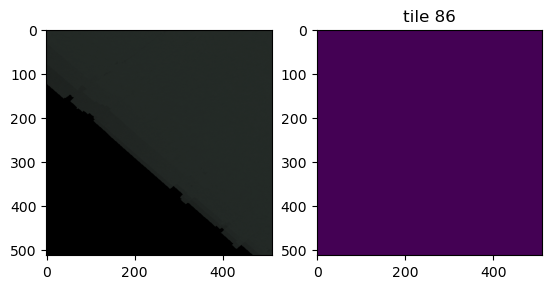

In [65]:
_, (ax0, ax1) = plt.subplots(1, 2)
k = np.random.randint(0, X_train.shape[0] - 1)
k = 86
x = X_train[k]
y = y_train[k]
print("xmin:", x.min())
idx = x[x==0].astype(np.uint8)
x[idx] = np.nan
y[idx] = np.nan
ax0.imshow(x)
ax1.imshow(y)
plt.title(f"tile {k}")